Medium post: https://medium.com/@gabogarza/exoplanet-hunting-with-machine-learning-and-kepler-data-recall-100-155e1ddeaa95

Github repo: https://github.com/gabrielgarza/exoplanet-deep-learning

In [28]:
path_to_data = '/home/menegattig/Downloads'

### Import libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from scipy import ndimage, fft
from sklearn.preprocessing import normalize
import os
root_dir = f"{path_to_data}/data_no_injection"
print(os.listdir(root_dir))


['exoTest.csv', 'exoTrain.csv']


## Data Preprocessor

In [30]:
import pandas as pd
import numpy as np
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform,axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform,axis=1)

            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x):
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x):
                df_dev_x_build[ii] = x
            
            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)


            # Keep first half of data as it is symmetrical after previous steps
            df_train_x = df_train_x.iloc[:,:(df_train_x.shape[1]//2)].values
            df_dev_x = df_dev_x.iloc[:,:(df_dev_x.shape[1]//2)].values

        # Normalize
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x))
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)


        # Gaussian filter to smooth out data
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            # Standardize X data
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x


### Load datasets

In [31]:
train_dataset_path = os.path.join(root_dir, "./exoTrain.csv")
dev_dataset_path = os.path.join(root_dir, "./exoTest.csv")

print("Loading datasets...")
df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")
print("Loaded datasets!")

# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_dev_x = df_dev.drop('LABEL', axis=1)
df_train_y = df_train.LABEL
df_dev_y = df_dev.LABEL
df_train

Loading datasets...
Loaded datasets!


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


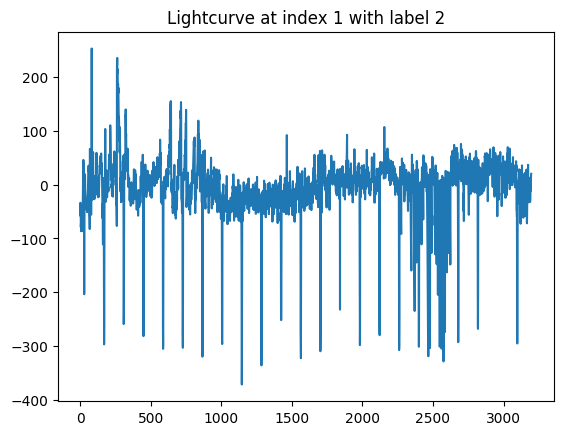

In [32]:
data = df_train_x.to_numpy()
ii = 0
while ii < len(data):
    index = np.random.randint(0, len(data))
    label = df_train_y[index]
    if label == 2.0:
        plt.figure()
        plt.plot(range(len(data[index, :])), data[index, :])
        plt.title(f"Lightcurve at index {index} with label {label}")
        break
    ii += 1

### Process data and create numpy matrices

In [33]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [34]:
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=True,
    gaussian=True,
    standardize=True)
df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

# display(df_train_x)


# Rejoin X and Y
df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

# Load X and Y numpy arrays
X_train, Y_train = np_X_Y_from_df(df_train_processed)
X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!


### Describe datasets

In [35]:
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[1] # n_y : output size
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1


## Train and test the lInear Model

In [36]:
model = LinearSVC(C=0.1)


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm)

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
## Calculate and Display Metrics
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...


/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished Training!
 
 
Train Set Error 0.0
Dev Set Error 0.0035087719298245723
------------
Precision - Train Set 1.0
Precision - Dev Set 0.7142857142857143
------------
Recall - Train Set 1.0
Recall - Dev Set 1.0
------------
Confusion Matrix - Train Set
[[5050    0]
 [   0   37]]
Confusion Matrix - Dev Set
[[563   2]
 [  0   5]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5050
        True       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

classification_report_dev
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       565
        True       0.71      1.00      0.83         5

    accuracy                           1.00       570
   macro avg       0.86      1.00     

## Polynomial Kernel

In [37]:
model = SVC(kernel = 'poly', degree=4, C=0.1)


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm)

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
## Calculate and Display Metrics
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...


/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished Training!
 
 
Train Set Error 0.00019657951641438576
Dev Set Error 0.00877192982456143
------------
Precision - Train Set 1.0
Precision - Dev Set 0.0
------------
Recall - Train Set 0.972972972972973
Recall - Dev Set 0.0
------------
Confusion Matrix - Train Set
[[5050    0]
 [   1   36]]
Confusion Matrix - Dev Set
[[565   0]
 [  5   0]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5050
        True       1.00      0.97      0.99        37

    accuracy                           1.00      5087
   macro avg       1.00      0.99      0.99      5087
weighted avg       1.00      1.00      1.00      5087

classification_report_dev
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       565
        True       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.5

/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

## Gaussian Kernel

In [41]:
model = SVC(kernel='rbf', C=1e3)


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm)

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
## Calculate and Display Metrics
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...


/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished Training!
 
 
Train Set Error 0.0
Dev Set Error 0.00877192982456143
------------
Precision - Train Set 1.0
Precision - Dev Set 0.0
------------
Recall - Train Set 1.0
Recall - Dev Set 0.0
------------
Confusion Matrix - Train Set
[[5050    0]
 [   0   37]]
Confusion Matrix - Dev Set
[[565   0]
 [  5   0]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5050
        True       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

classification_report_dev
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       565
        True       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
w

/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

# Plotting the results of the tests

/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/menegattig/.pyenv/ver

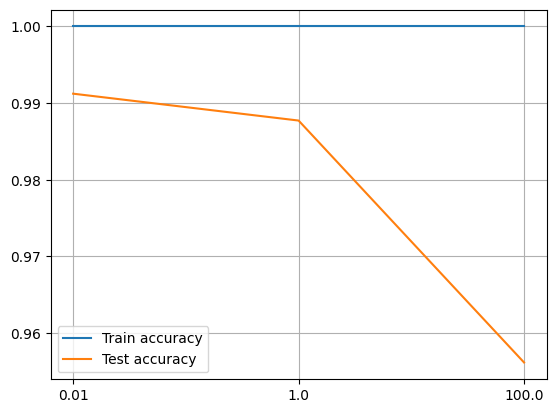

In [45]:
test_acc = []
train_acc = []
test_prec = []
train_prec = []
C = [1e-2, 1.0, 1e2]

for c in C:
    model = LinearSVC(C=c)
    model.fit(X_train_sm, Y_train_sm)

    train_outputs = np.rint(model.predict(X_train_sm))
    dev_outputs = np.rint(model.predict(X_dev))

    train_acc.append(accuracy_score(Y_train_sm, train_outputs))
    test_acc.append(accuracy_score(Y_dev, dev_outputs))
    train_prec.append(precision_score(Y_train_sm, train_outputs))
    test_prec.append(precision_score(Y_dev, dev_outputs))

plt.plot([str(c) for c in C], train_acc, label='Train accuracy')
plt.plot([str(c) for c in C], test_acc, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()